# Creation of a Connectivity Matrix

Some variables taken from the other Notebooks

In [34]:
import xarray as xr
import numpy as np
from scipy.spatial import KDTree
from scipy.sparse import lil_matrix
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

In [150]:
ds_part= xr.open_zarr("/mnt/iscsi2/OceanParcels/resultsObsDom/November97_100days.zarr")

In [151]:
new_corals_lat=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_latitude.npy')
new_corals_lon=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_longitude.npy')

### Time and location of particles at the starting time and after 7, 30 and 70 days of advection

In [166]:
time_reduced_0 = ds_part.time.isel(obs=0).values
lon_reduced_0 = ds_part.lon.isel(obs=0).values
lat_reduced_0 = ds_part.lat.isel(obs=0).values

time_reduced_end = ds_part.time.isel(obs=7*24).values
lon_reduced_end = ds_part.lon.isel(obs=7*24).values
lat_reduced_end = ds_part.lat.isel(obs=7*24).values

### Substitution of the starting location of the trajectories with the closest point among the 46 coral grouped spots

For the function KDTree see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

In [167]:
# Combine coral reef points into a single array
reef_points_38 = np.column_stack((new_corals_lon, new_corals_lat))

# Build KDTree for coral reef points
reef_tree_38 = KDTree(reef_points_38)

# Query KDTree for closest reef point to each starting point
distances_38, indices_38 = reef_tree_38.query(np.column_stack((lon_reduced_0, lat_reduced_0)), k=1)

# Get closest reef points
closest_reef_lon_38 = new_corals_lon[indices_38]
closest_reef_lat_38 = new_corals_lat[indices_38]

### Key variables for the creation of the Matrix

In [168]:
filtered_lon_list=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/filtered_lon_list.npy')
filtered_lat_list=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/filtered_lat_list.npy')

In [169]:
# Proximity threshold (approx 2.2 km)
proximity_threshold = 0.02

# Number of spots
n_grouped_spots = len(new_corals_lon)
n_small_spots = len(filtered_lon_list)

Workflow of the 38x38 Matrix creation:
- Get a matrix with 38 starting spots and with 1025 possible ending spots (38x1025 matrix)
- Link every possible ending spots among the 1025 to the closest grouped spots among the 38
- Update the matrix with 38 starting spots and 38 ending spots (38x38 matrix)
- Get the matrix in an array form
- To assign to 0 values (so no connections between spots) a nan value, transform the matrix into a float

In [170]:
# Initialize the connectivity matrix as a sparse matrix
connectivity_matrix = lil_matrix((n_grouped_spots, n_grouped_spots), dtype=int)

# Function to find indices of nearest points within a threshold
def find_nearest_reefs(lat, lon, reef_lats, reef_lons, threshold):
    lat_diff = np.abs(reef_lats - lat)
    lon_diff = np.abs(reef_lons - lon)
    mask = (lat_diff <= threshold) & (lon_diff <= threshold)
    return np.where(mask)[0]

# Function to find the index of the nearest point among grouped coral spots
def find_nearest_grouped_index(lat, lon, grouped_lats, grouped_lons):
    distances = cdist([[lat, lon]], np.column_stack((new_corals_lat, new_corals_lon)))
    return np.argmin(distances)

# Process each of the 38 grouped starting positions
for i in range(n_grouped_spots):
    start_lon = new_corals_lon[i]
    start_lat = new_corals_lat[i]

    # Find particles that started from the i-th grouped coral reef spot
    particles_at_start = np.where((closest_reef_lon_38 == start_lon) & (closest_reef_lat_38 == start_lat))[0]

    # Positions after 7 days for these particles
    end_lats = lat_reduced_end[particles_at_start]
    end_lons = lon_reduced_end[particles_at_start]

    # Remove NaN and Inf values
    finite_mask = np.isfinite(end_lats) & np.isfinite(end_lons)
    end_lats = end_lats[finite_mask]
    end_lons = end_lons[finite_mask]

    # Find nearest reef spots for end positions
    for end_lat, end_lon in zip(end_lats, end_lons):
        nearest_reef_indices = find_nearest_reefs(end_lat, end_lon, filtered_lat_list, filtered_lon_list, proximity_threshold)
        
        for reef_idx in nearest_reef_indices:
            # Get the coordinates of the nearest reef
            reef_lat = filtered_lat_list[reef_idx]
            reef_lon = filtered_lon_list[reef_idx]
            
            # Find the nearest grouped coral spot to this reef
            closest_grouped_index = find_nearest_grouped_index(reef_lat, reef_lon, new_corals_lat, new_corals_lon)
            
            # Update the connectivity matrix
            connectivity_matrix[i, closest_grouped_index] += 1

connectivity_matrix_array = connectivity_matrix.toarray()

In [171]:
# Matrix --> float and 0 --> nan
connectivity_matrix_array_nan = connectivity_matrix_array.astype(float)
connectivity_matrix_array_nan[connectivity_matrix_array_nan == 0] = np.nan

In [172]:
np.save('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_November97_7days.npy',connectivity_matrix_array_nan)

Manipulation of the matrix for plotting

In [16]:
row_sums = np.nansum(connectivity_matrix_array_nan, axis=1, keepdims=True)
connectivity_matrix = ( connectivity_matrix_array/ row_sums) * 100

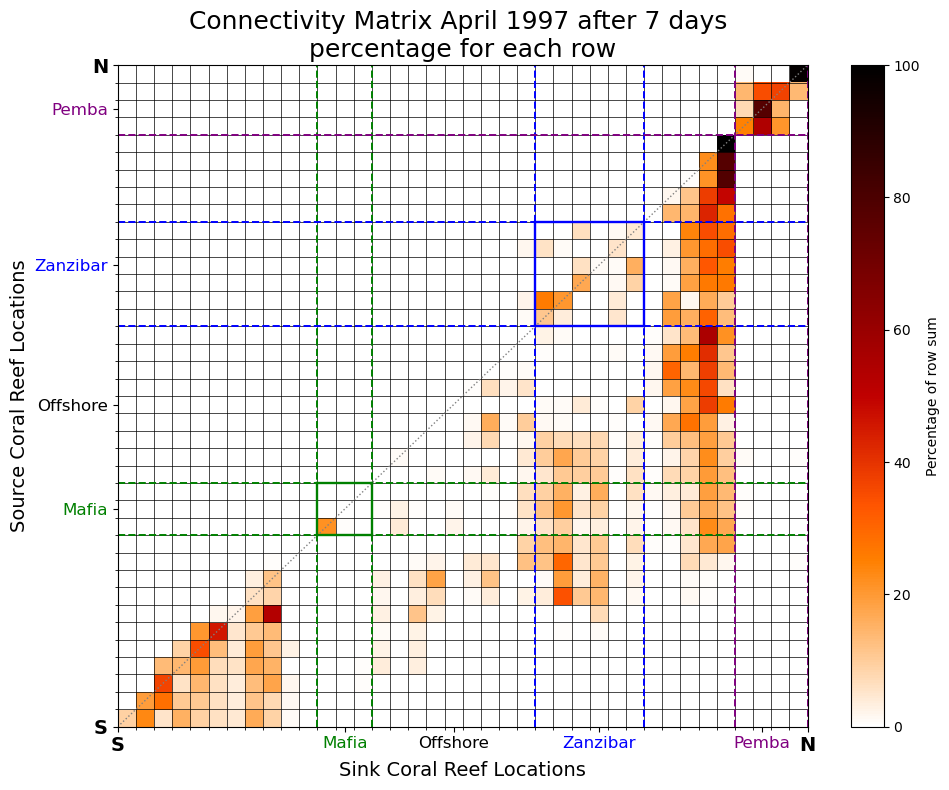

In [33]:
plt.figure(figsize=(10, 8))

plt.imshow(connectivity_matrix, cmap='gist_heat_r',
           interpolation='nearest', aspect='auto', vmax=100, vmin=0)
plt.gca().invert_yaxis()

plt.colorbar(label='Percentage of row sum')
plt.title('Connectivity Matrix April 1997 after 7 days \npercentage for each row', fontsize=18)
plt.xlabel('Sink Coral Reef Locations', fontsize=14)
plt.ylabel('Source Coral Reef Locations', fontsize=14)
plt.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
plt.gca().set_xticks(np.arange(-0.5, 38.5, 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, 38.5, 1), minor=True)

plt.plot([-0.5, 37.5], [-0.5, 37.5], color='grey', linewidth=1, linestyle='dotted')

Mafia = [11, 14]
for row in Mafia:
    plt.axhline(y=row - 0.5, color='g', linewidth=1.4, linestyle='--')
    plt.axhline(y=row - 0.5, xmin=11/38, xmax=14/38, color='g', linewidth=1.7, linestyle='-')
    plt.axvline(x=row - 0.5, color='g', linewidth=1.4, linestyle='--')
    plt.axvline(x=row - 0.5, ymin=11/38, ymax=14/38, color='g', linewidth=1.7, linestyle='-')
    
    
Zanzibar = [23, 29]
for row in Zanzibar:
    plt.axhline(y=row - 0.5, color='b', linewidth=1.4, linestyle='--')
    plt.axhline(y=row - 0.5, xmin=23/38, xmax=29/38, color='b', linewidth=1.7, linestyle='-')
    plt.axvline(x=row - 0.5, color='b', linewidth=1.4, linestyle='--')
    plt.axvline(x=row - 0.5, ymin=23/38, ymax=29/38, color='b', linewidth=1.7, linestyle='-')


Pemba_rows = [34, 38]
for row in Pemba_rows:
    plt.axhline(y=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
    plt.axhline(y=row - 0.5, xmin=34/38, xmax=38/38, color='purple', linewidth=1.7, linestyle='-')
    plt.axvline(x=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
    plt.axvline(x=row - 0.5, ymin=34/38, ymax=38/38, color='purple', linewidth=1.7, linestyle='-')    
    


specific_ticks = [-0.5, 12, 18, 26, 35, 37.5]
tick_labels = ['S', 'Mafia', 'Offshore', 'Zanzibar', 'Pemba', 'N']
plt.xticks(ticks=specific_ticks, labels=tick_labels, rotation=0)
plt.yticks(ticks=specific_ticks, labels=tick_labels, rotation=0)

ax = plt.gca()
tick_colors = {'S': 'black', 'Mafia': 'g', 'Offshore': 'k', 'Zanzibar': 'b', 'Pemba': 'purple', 'N': 'black'}

for label in ax.get_xticklabels():
    text = label.get_text()
    if text in tick_colors:
        label.set_fontsize(12)
        label.set_color(tick_colors[text])
        if text in ['S', 'N']:
            label.set_fontsize(14)
            label.set_fontweight('bold')

for label in ax.get_yticklabels():
    text = label.get_text()
    if text in tick_colors:
        label.set_fontsize(12)
        label.set_color(tick_colors[text])
        if text in ['S', 'N']:
            label.set_fontsize(14)
            label.set_fontweight('bold')

plt.tight_layout()


In [ ]:


Pemba_rows = [33, 38]
for row in Pemba_rows:
    plt.axhline(y=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
    plt.axhline(y=row - 0.5, xmin=33/38, xmax=38/38, color='purple', linewidth=1.7, linestyle='-')
    plt.axvline(x=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
    plt.axvline(x=row - 0.5, ymin=33/38, ymax=38/38, color='purple', linewidth=1.7, linestyle='-')




In [ ]:
np.save('/mnt/iscsi2/OceanParcels/Analysis_ExtDomain/connectivity_matrix_November99_70days.npy',connectivity_matrix_array_nan)